<a href="https://colab.research.google.com/github/itzThillaiC/Astronomical-image-denoiser/blob/main/SRGAN_model20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the required packages

In [2]:
import os
import random
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
IMAGES_PATH = '/content/drive/My Drive/Galaxy10/'
IMAGES = os.listdir(IMAGES_PATH)
random.shuffle(IMAGES)

In [4]:
len(IMAGES)

503

Assigning the device as cuda if GPU is available else cpu

In [5]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

Defining the generator architecture as given the reference paper

In [6]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

Assigning the Generator to cuda(if available) and printing the summary of the Generator with a dummy input

In [7]:
gen = Generator().to(cuda)

#Uncomment below mentioned three lines if you have more than one gpu and want to use all of them
#ngpu=2
# if (cuda.type == 'cuda') and (ngpu > 1):
#     gen = n.DataParallel(gen, list(range(ngpu)))
summary(gen,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

Defining the Discriminator network as given in the reference paper expect that a dropout in the last layer

In [8]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

Assigning the discriminator to the gpu(if available) and printing the summary of the network with a dummy value

In [9]:
disc = Discriminator().to(cuda)
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
            Conv2d-2         [-1, 64, 128, 128]          36,864
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
           Conv2d-10          [-1, 256, 32, 32]         589,824
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 512, 32, 32]       1,179,648
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
           Conv2d-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [10]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

Downloading the pretrained vgg19 model from model module of torchvision library

In [11]:
vgg = models.vgg19(pretrained=True).to(cuda)

Defining the losses to be used in training

In [12]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

Defining the adam optimizers for generator and discriminator

In [13]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

Loading the images after based on resizing as numpy array

In [14]:
def loadImages(IMAGES,path,resize=False):
    images=[]
    for image in (IMAGES):
#         print(image)
        if resize:
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256)) 
        else:
            img = cv2.imread(os.path.join(path,image))
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
#         print(img.shape)
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

Converting the high resolution images into low resolution by applying gaussian blur, resizing in to 64*64 and loading it as numpy array

In [15]:
def loadLRImages(IMAGES,path):
    images=[]
    for image in (IMAGES):
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        img = np.moveaxis(img, 2, 0)
        images.append(img)
    return np.array(images)

Loading the generator model from the given checkpoint

In [16]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

Given low resolution images and checkpoint, Generating the high resolution images out of it 

In [17]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
#     imagearray = (imagedir)/255
    # imagearrayPT = np.reshape(imagearray,(len(imagelist),imagearray.shape[3],imagearray.shape[1],imagearray.shape[2]))
    imagearrayPT = np.moveaxis(imagearray,3,1)
    # print(imagearrayPT.shape)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    # print(out_tensor.shape)
    # out = np.reshape(out_tensor,[out_tensor.shape[0],out_tensor.shape[2],out_tensor.shape[3],out_tensor.shape[1]])
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    # print(out.shape)
    out = np.clip(out,0,1)
    
    return out

Display utility of displaying images using matplotlib

In [18]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [19]:
#change the batch-size based on your system memory

epochs=20
batch_size=5

In [20]:
import os 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path =IMAGES_PATH
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

    
#LR_images_list = os.listdir(lr_path)
HR_images_list = IMAGES
batch_count = len(HR_images_list)//batch_size
batch_count

100

Starting of training and defining losses

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch ::::  1  d1_loss ::: 0.4726349801967498  d2_loss :::0.32011725368913296
genLoss ::: 12.582632082108814  vggLoss ::: 0.05174693238611023  MeanLoss  ::: 0.0038258819802043337


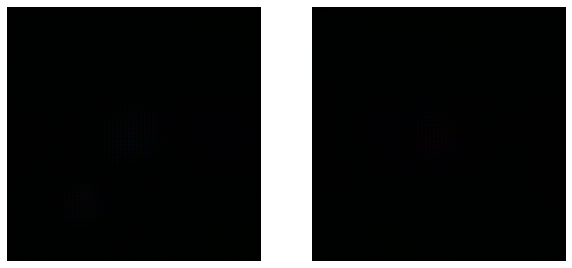

100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


Epoch ::::  2  d1_loss ::: 0.21837266744106026  d2_loss :::0.26108304836950347
genLoss ::: 23.43035669326782  vggLoss ::: 0.029512021380166214  MeanLoss  ::: 0.0018200928985606878


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch ::::  3  d1_loss ::: 0.27985395445789746  d2_loss :::0.2053846105967791
genLoss ::: 22.29715452194214  vggLoss ::: 0.028033560669670502  MeanLoss  ::: 0.0016134332690853626


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch ::::  4  d1_loss ::: 0.2052237660124168  d2_loss :::0.23501584047400045
genLoss ::: 30.589153297742207  vggLoss ::: 0.025923939328640698  MeanLoss  ::: 0.001439047697931528


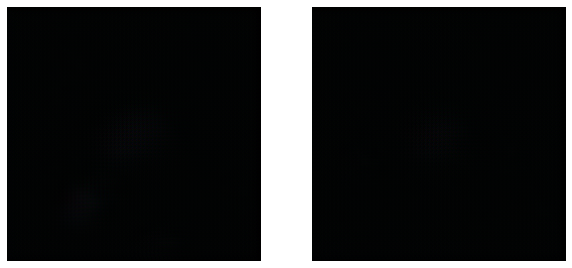

100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch ::::  5  d1_loss ::: 0.5389723905928501  d2_loss :::0.22411759535471604
genLoss ::: 48.1104195078214  vggLoss ::: 0.02315396557872494  MeanLoss  ::: 0.0012594514962984249


100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch ::::  6  d1_loss ::: 0.19662098421404792  d2_loss :::0.1779077844818442
genLoss ::: 47.906611585617064  vggLoss ::: 0.02101884614676237  MeanLoss  ::: 0.0011370660475222393


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch ::::  7  d1_loss ::: 0.2097497475147262  d2_loss :::0.20832874154051145
genLoss ::: 54.10444666544596  vggLoss ::: 0.019895413673172394  MeanLoss  ::: 0.00106379613619841


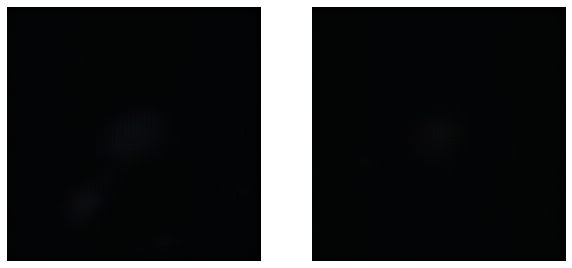

100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch ::::  8  d1_loss ::: 0.22531401043136914  d2_loss :::0.22470361779245043
genLoss ::: 37.69649656613668  vggLoss ::: 0.019301827143256862  MeanLoss  ::: 0.0010093694630389412


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch ::::  9  d1_loss ::: 0.17790777683258058  d2_loss :::0.19870219230651856
genLoss ::: 53.80429674784342  vggLoss ::: 0.018928184639662504  MeanLoss  ::: 0.0009665131952109125


100%|██████████| 60/60 [00:20<00:00,  2.94it/s]


Epoch ::::  10  d1_loss ::: 0.21487562656402587  d2_loss :::0.19177072048187255
genLoss ::: 46.9176504611969  vggLoss ::: 0.01866158962560197  MeanLoss  ::: 0.0009231807135317165


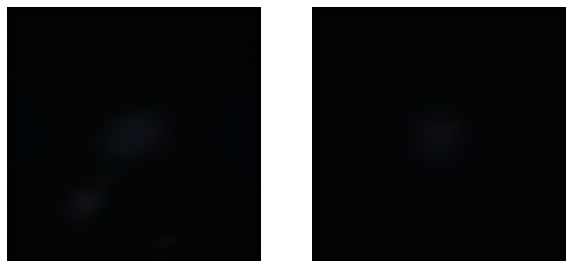

100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch ::::  11  d1_loss ::: 0.20563366413116455  d2_loss :::0.19408121109008789
genLoss ::: 44.11482725143433  vggLoss ::: 0.018455830480282504  MeanLoss  ::: 0.0008709429147226426


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch ::::  12  d1_loss ::: 0.20672326082984605  d2_loss :::0.32717975601553917
genLoss ::: 48.59911398887634  vggLoss ::: 0.018269186715284984  MeanLoss  ::: 0.000815451761688261


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch ::::  13  d1_loss ::: 0.21170112291971843  d2_loss :::0.19640882998716858
genLoss ::: 65.59657742182414  vggLoss ::: 0.018095793994143607  MeanLoss  ::: 0.000767530868082152


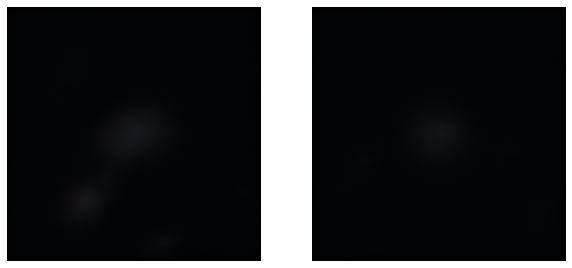

100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch ::::  14  d1_loss ::: 0.22873857021331787  d2_loss :::0.19878004422923487
genLoss ::: 67.22874052524567  vggLoss ::: 0.01794440148708721  MeanLoss  ::: 0.0007286298471929816


100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch ::::  15  d1_loss ::: 0.21256513595581056  d2_loss :::0.19870227396492623
genLoss ::: 69.54590028127035  vggLoss ::: 0.017813635353619853  MeanLoss  ::: 0.0006980474126370002


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch ::::  16  d1_loss ::: 0.21487562656402587  d2_loss :::0.2241177801787984
genLoss ::: 69.2148778518041  vggLoss ::: 0.017699499684385955  MeanLoss  ::: 0.0006653914999333211


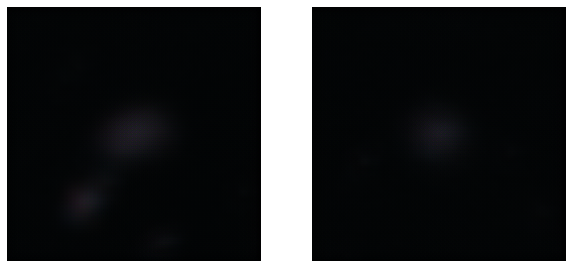

100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch ::::  17  d1_loss ::: 0.2310490608215332  d2_loss :::0.22873872165881437
genLoss ::: 66.89771763483684  vggLoss ::: 0.01759185903550436  MeanLoss  ::: 0.0006388976789215424


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch ::::  18  d1_loss ::: 0.2310490608215332  d2_loss :::0.21256532073020934
genLoss ::: 66.89771769841512  vggLoss ::: 0.01749768340184043  MeanLoss  ::: 0.0006123674570214159


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch ::::  19  d1_loss ::: 0.2449120044708252  d2_loss :::0.17328697686399247
genLoss ::: 64.91158056259155  vggLoss ::: 0.017407561116851867  MeanLoss  ::: 0.0006017028009713006


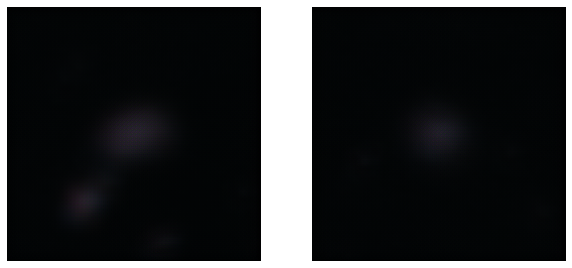

100%|██████████| 60/60 [00:20<00:00,  2.95it/s]

Epoch ::::  20  d1_loss ::: 0.24260151386260986  d2_loss :::0.21949677894516614
genLoss ::: 65.24260339736938  vggLoss ::: 0.017333530782101054  MeanLoss  ::: 0.0005836042953887954


In [21]:
batch_count=60
import torch
torch.cuda.empty_cache()
for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
     

    
    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255
        
                
        disc.zero_grad()

        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        # d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        # print(d1_loss,d2_loss)
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()
        

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())
        
        generator_loss = g_loss + v_loss + m_loss
        # v_loss.backward(retain_graph=True)
        # m_loss.backward(retain_graph=True)
        # g_loss.backward()
        # print(generator_loss)

        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

        
        
#         print("d1Loss ::: "+str((d1_loss.item()))+" d2Loss ::: "+str((d2_loss.item())))
#         print("gloss ::: "+str((g_loss.item()))+" vloss ::: "+str((v_loss.item()))+" mloss ::: "+str((m_loss.item())))
    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        out_images = imagePostProcess(IMAGES[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
#         print(out_images.shape)
#         test_images = loadLRImages(images[:-3],hr_path)/255
#         test_images = np.reshape(test_images,(test_images[0],test_images.shape[3],test_images.shape[1],test_images.shape[2]))
#         out_images = gen(torch.from_numpy(test_images).to(cuda).float())
#         out_images = np.reshape(out_images,(out_images[0],out_images[2],out_images[3],out_images[1]))
        show_samples(out_images)
        